# Ratio Approach (Load Factor)

In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd

from scripts.python.tsa.mtsmodel import *
from scripts.python.tsa.ts_eval import *

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt


PALAU's Official and Avaition Data.

 Create Loaded Factor for PALAU:
Abnormal value produced with a value of inf.

 Regression PALAU:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.762
Model:                            WLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     16.95
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           8.36e-10
Time:                        20:28:09   Log-Likelihood:                 34.253
No. Observations:                  45   AIC:                            -52.51
Df Residuals:                      37   BIC:                            -38.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.561695,7329.0,13048.0,0.568387,0.051942,0.463144,0.673631,0.294774,0.842001,7416.318832
1,2019-02-01,0.734282,9752.0,13281.0,0.615828,0.047496,0.519592,0.712064,0.345551,0.886105,8178.810659
2,2019-03-01,0.701865,9033.0,12870.0,0.618136,0.047401,0.522092,0.714181,0.347928,0.888345,7955.416496
3,2019-04-01,0.777809,8405.0,10806.0,0.596816,0.048248,0.499057,0.694575,0.325993,0.867639,6449.194875
4,2019-05-01,0.651848,7478.0,11472.0,0.505042,0.059329,0.384831,0.625253,0.225330,0.784754,5793.840076


,MSE,RMSE,MAE,SMAPE
mean,1.219030e+07,3491.460526,3125.890370,130.888109
naive,1.298621e+06,1139.570483,677.477273,53.868245
ratio,4.945034e+05,703.209346,389.892735,40.776367


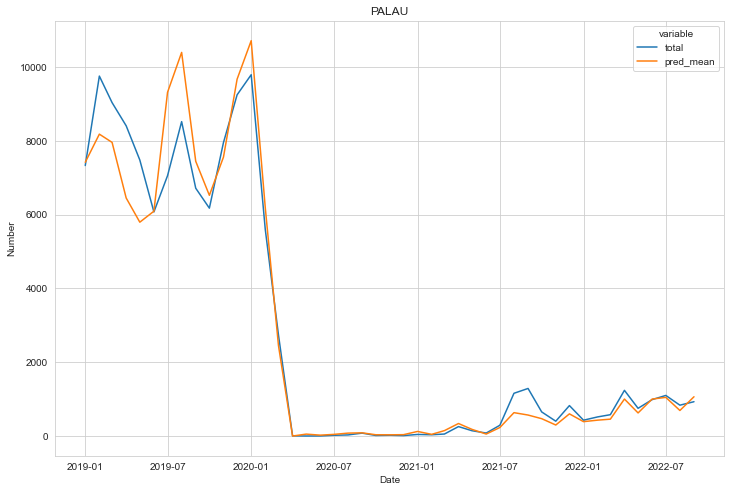


SAMOA's Official and Avaition Data.

 Create Loaded Factor for SAMOA:

 Regression SAMOA:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.850
Model:                            WLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     29.93
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           2.19e-13
Time:                        20:28:10   Log-Likelihood:                 30.672
No. Observations:                  45   AIC:                            -45.34
Df Residuals:                      37   BIC:                            -30.89
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.522368,13755.0,26332.0,0.621337,0.056744,0.506363,0.736310,0.324664,0.918009,16361.033442
1,2019-02-01,0.522171,9044.0,17320.0,0.546506,0.053121,0.438872,0.654139,0.252599,0.840412,9465.476885
2,2019-03-01,0.535575,11163.0,20843.0,0.527865,0.056717,0.412946,0.642784,0.231213,0.824517,11002.290740
3,2019-04-01,0.692899,14413.0,20801.0,0.573619,0.067122,0.437616,0.709622,0.268180,0.879057,11931.843012
4,2019-05-01,0.650818,13565.0,20843.0,0.661691,0.052208,0.555909,0.767474,0.368458,0.954925,13791.631497


,MSE,RMSE,MAE,SMAPE
mean,4.747392e+07,6890.131975,6027.062716,155.537953
naive,7.970104e+06,2823.137282,1518.795455,49.120902
ratio,2.107651e+06,1451.775046,763.990597,131.108537


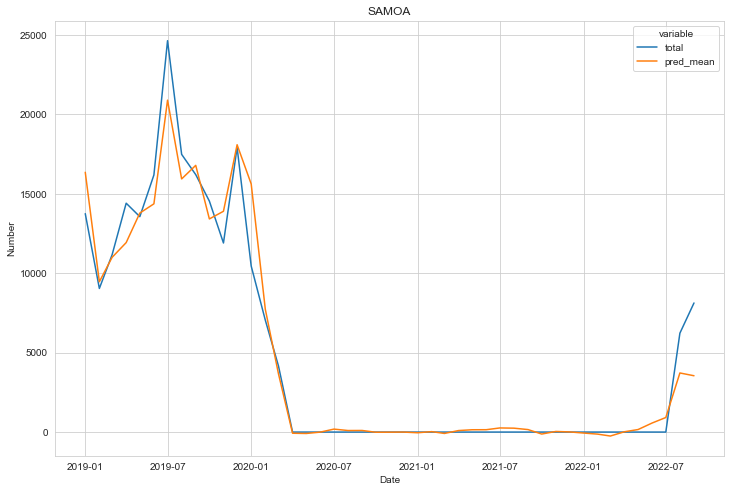


TONGA's Official and Avaition Data.

 Create Loaded Factor for TONGA:

 Regression TONGA:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.953
Model:                            WLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     80.41
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           7.60e-17
Time:                        20:28:11   Log-Likelihood:                 60.571
No. Observations:                  36   AIC:                            -105.1
Df Residuals:                      28   BIC:                            -92.47
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.297294,4372,14706.0,0.359100,0.023178,0.311623,0.406577,0.244337,0.473863,5280.927090
1,2019-02-01,0.278131,2709,9740.0,0.360868,0.022227,0.315339,0.406397,0.246897,0.474839,3514.852693
2,2019-03-01,0.303732,3109,10236.0,0.363279,0.021470,0.319299,0.407259,0.249918,0.476640,3718.522264
3,2019-04-01,0.394065,4183,10615.0,0.439962,0.025482,0.387764,0.492159,0.323167,0.556757,4670.193497
4,2019-05-01,0.435655,5166,11858.0,0.447279,0.021431,0.403380,0.491178,0.333949,0.560609,5303.835766


,MSE,RMSE,MAE,SMAPE
mean,7.898678e+06,2810.458659,2511.586420,147.552078
naive,1.045461e+06,1022.477747,597.257143,69.556373
ratio,2.036229e+05,451.245944,258.523902,87.345914


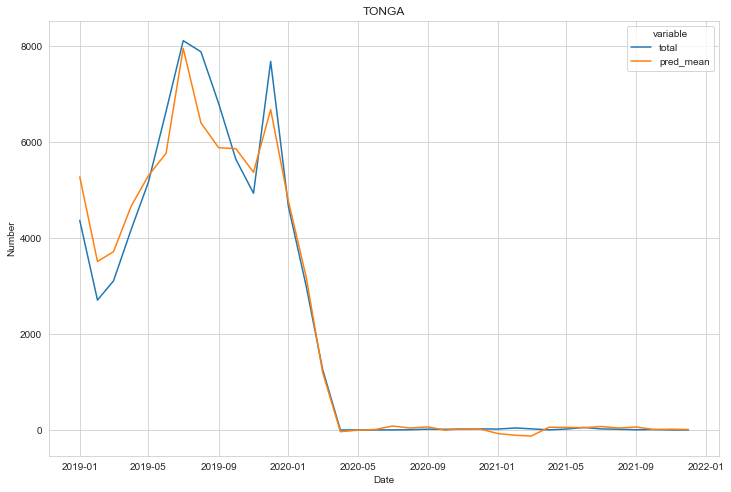


SOLOMON_ISLANDS's Official and Avaition Data.

 Create Loaded Factor for SOLOMON_ISLANDS:

 Regression SOLOMON_ISLANDS:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.939
Model:                            WLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     35.46
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           1.40e-08
Time:                        20:28:12   Log-Likelihood:                 54.264
No. Observations:                  24   AIC:                            -92.53
Df Residuals:                      16   BIC:                            -83.10
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.174372,1750,10036.0,0.212880,0.017319,0.176165,0.249595,0.137798,0.287962,2136.464988
1,2019-02-01,0.199662,1891,9471.0,0.208311,0.015656,0.175121,0.241501,0.134889,0.281734,1972.917412
2,2019-03-01,0.245332,2378,9693.0,0.201838,0.019636,0.160211,0.243464,0.124236,0.279439,1956.411325
3,2019-04-01,0.220940,2106,9532.0,0.242741,0.016423,0.207926,0.277556,0.168570,0.316912,2313.809745
4,2019-05-01,0.246881,2434,9859.0,0.252211,0.019415,0.211054,0.293368,0.174860,0.329562,2486.545575


,MSE,RMSE,MAE,SMAPE
mean,1.290167e+06,1135.855000,1065.215278,100.969388
naive,1.721267e+05,414.881597,268.478261,46.835106
ratio,4.875343e+04,220.801780,150.232442,26.614403


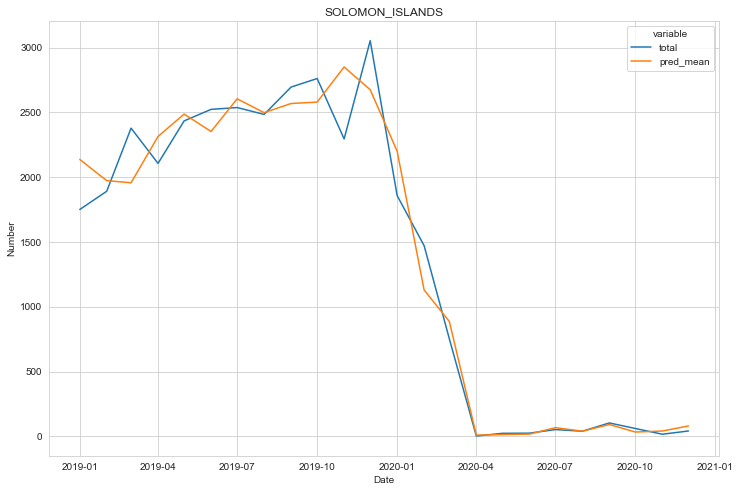


VANUATU's Official and Avaition Data.

 Create Loaded Factor for VANUATU:

 Regression VANUATU:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.951
Model:                            WLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     91.83
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           8.77e-20
Time:                        20:28:14   Log-Likelihood:                 51.937
No. Observations:                  41   AIC:                            -87.87
Df Residuals:                      33   BIC:                            -74.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.514218,9548.0,18568.0,0.588312,0.029328,0.528643,0.647980,0.422595,0.754029,10923.776403
1,2019-02-01,0.426535,5835.0,13680.0,0.572673,0.030753,0.510106,0.635239,0.405890,0.739455,7834.160478
2,2019-03-01,0.475565,7026.0,14774.0,0.599281,0.028877,0.540530,0.658033,0.433893,0.764670,8853.783974
3,2019-04-01,0.553277,9445.0,17071.0,0.637386,0.030901,0.574518,0.700254,0.470490,0.804281,10880.813055
4,2019-05-01,0.498628,8359.0,16764.0,0.609568,0.030275,0.547974,0.671163,0.443148,0.775988,10218.804304


,MSE,RMSE,MAE,SMAPE
mean,2.273834e+07,4768.473803,4264.861006,156.566459
naive,2.446383e+06,1564.091833,808.452381,45.153360
ratio,6.686460e+05,817.707761,520.156920,128.001919


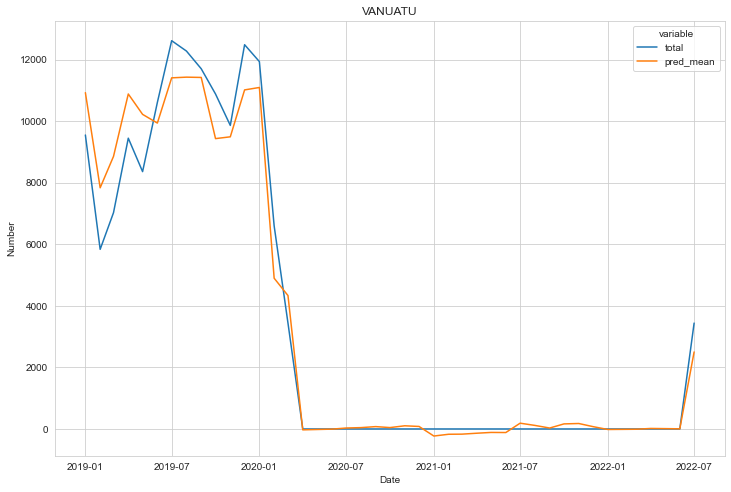

In [2]:
for country in ["palau", "samoa", "tonga", "solomon_islands", "vanuatu"]:
    
    mod = RatioPipe(country=country, data=None)
    print(f"\n{country.upper()}'s Official and Avaition Data.")
    mod.read_and_merge()
    
    print(f"\n Create Loaded Factor for {country.upper()}:")
    mod.transform()
    
    print(f"\n Regression {country.upper()}:")
    mod.fit()
    pred_df = mod.get_prediction_df()

    mean_pred, naive_pred = \
        mean_method(pred_df["total"]), naive_method(pred_df["total"])
    
    benchmark = pd.DataFrame()
    eval_name = ["mean", "naive", "ratio"]
    for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
        eval_df = pd.DataFrame(calculate_evaluation(pred_df["total"], pred), index=[idx])
        benchmark = pd.concat([benchmark, eval_df])
    display(benchmark)
    
    benchmark.to_csv(mod.country_data_folder + "/model/lf_eval_" + str(country) + ".csv", 
                     encoding="utf-8")
    
    saved_pred_path = mod.country_data_folder + "/model/lf_" + str(country) + ".csv"
    pred_df.to_csv(saved_pred_path, encoding="utf-8")
    
    ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
    ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
    plt.show()
    